<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/DS_module_project_221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [2]:
import pandas as pd

df = pd.merge(pd.read_csv(DATA_PATH + 'waterpumps/train_features.csv'),
              pd.read_csv(DATA_PATH + 'waterpumps/train_labels.csv'))

# YOUR CODE HERE
df = df.set_index('id')

df.head()

amount_tsh date_recorded  ... waterpoint_type_group    status_group
id                               ...                                      
69572      6000.0    2011-03-14  ...    communal standpipe      functional
8776          0.0    2013-03-06  ...    communal standpipe      functional
34310        25.0    2013-02-25  ...    communal standpipe      functional
67743         0.0    2013-01-28  ...    communal standpipe  non functional
19728         0.0    2011-07-13  ...    communal standpipe      functional

[5 rows x 40 columns]

**Test 2**

In [3]:
'''Task 2 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created the DataFrame `df`?'
assert df.shape == (59400, 40), '`df` is the wrong shape. Did you set the index to `id`?'
assert 69572 in df.index, 'The index for `df` is has the wrong values. Did you set the index to `id`?'

In [4]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, minimal=True).to_notebook_iframe()

profile

In [5]:
import numpy as np
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="TanzaniaWater")


# We will use the lat/long for the basin for the missing lat/long
# Since the basin is either Lake Victoria or Lake Tanganyika for 
# the entries with missing lat/long, we set up a dictionary
# with the lat/long for those 2 locations
# Lake Victoria      1713
# Lake Tanganyika      99

get_loc = lambda x: geolocator.geocode(x)
get_lat_long = lambda x: (get_loc(x).latitude, get_loc(x).longitude)

locs = {'Lake Victoria':{'latitude':0, 'longitude':0}, 'Lake Tanganyika':{'latitude':0, 'longitude':0}}

for loc in locs:
  locs[loc]['latitude'], locs[loc]['longitude'] = get_lat_long(loc)

# Looking up the data dictionary at https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list
# Create a list of redundant columns
# recorded_by - constant valued
# num_private - undefined and mostly zero
# extraction_type, extraction_type_group - the same information ia available in extraction_type_class
# payment - same as payment_type
# water_quality - same as quality_group
# quantity - same as quantity_group
# source, source_class - same as source_type
# waterpoint_type - waterpoint_type_group

red_cols = ['recorded_by', 'num_private','extraction_type','extraction_type_group','payment', 'water_quality', 'quantity', 'source', 'source_class', 'waterpoint_type']


# Get a series with the cardinality of the nonnumeric features
cardinality = df.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality > 50
high_card = cardinality[cardinality > 150].index.tolist()
print(high_card)

nan_drop = ['public_meeting', 'scheme_management', 'permit']

def wrangle(in_df, drop = red_cols+high_card+nan_drop):

  out_df = in_df.drop(columns=drop).copy()

  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  out_df['latitude'] = out_df['latitude'].replace(-2e-08, 0)
    
  # When columns have zeros and shouldn't, they are like null values.
  # A longitude or latitude of zero is outside Tanzania and therefore wrong.
  # So we will replace the zeros with nulls, and then fix them by using
  # the lat/long for the basin.
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
      out_df[col] = out_df[col].replace(0, np.nan)

  display(out_df[out_df.latitude.isna()].basin.value_counts())
  # Fix missing lat/long values
  for col in cols_with_zeros:
    out_df.loc[out_df[col].isna(), col] = out_df[out_df[col].isna()].basin.apply(lambda x: locs[x][col])
  
  print(out_df.isna().sum())
  print(out_df.shape)
  # return the wrangled dataframe
  return out_df


['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']


## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [6]:
target = 'status_group'

# YOUR CODE HERE

target = 'status_group'

X = df.drop(columns=[target]).copy()
y = df[target].copy()

**Test 3**

In [7]:
'''Task 3 Testing'''

assert isinstance(X, pd.DataFrame), '`X` is the wrong data type.'
assert isinstance(y, pd.Series), '`y` is the wrong data type.'
assert y.shape == (59400,), '`y` is the wrong shape.'
assert X.shape == (59400,39), '`X` is the wrong shape.'

We already have a test set for this model, the `test.csv` that you'll use to make the predictions you'll upload to Kaggle. However, since our competition only allows for 2 submissions per day, we need a way to estimate our training error so that we can quickly iterate and improve our model. We can achieve this by creating a validation set from the data we have.

**Task 4:** Split `X` and `y` into training and validation sets. Your validation set should be 20% of the data you have. You should have four variables: `X_train`, `X_val`, `y_train`, and `y_val`. 

In [8]:
from sklearn.model_selection import train_test_split

# YOUR CODE HERE

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.8, random_state=42)


**Test 4**

In [9]:
'''Task 4 Testing'''

assert X_train.shape == (47520, 39), '`X_train` is the wrong shape.'
assert X_val.shape == (11880, 39), '`X_val` is the wrong shape.'
assert y_train.shape == (47520,), '`y_train` is the wrong shape.'
assert y_val.shape == (11880,), '`y_val` is the wrong shape.'

## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [10]:
# YOUR CODE HERE

baseline_acc = y_train.value_counts(normalize=True)[0]

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5429713804713805


**Task 5**

In [11]:
'''Task 5 Testing'''

assert isinstance(baseline_acc, float), '`baseline_acc` should be a `float`.'
assert 0.0 <= baseline_acc <= 1.0, '`baseline_acc` is a score that should be between 0 and 1.'

In [12]:
display(X_train.head(5))
X_train = wrangle(X_train)
X_val = wrangle(X_val)

amount_tsh date_recorded  ...     waterpoint_type  waterpoint_type_group
id                               ...                                           
454          50.0    2013-02-27  ...  communal standpipe     communal standpipe
510           0.0    2011-03-17  ...           hand pump              hand pump
14146         0.0    2011-07-10  ...               other                  other
47410         0.0    2011-04-12  ...  communal standpipe     communal standpipe
1288        300.0    2011-04-05  ...               other                  other

[5 rows x 39 columns]

Lake Victoria      1355
Lake Tanganyika      78
Name: basin, dtype: int64

amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
population               0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
dtype: int64
(47520, 19)


Lake Victoria      358
Lake Tanganyika     21
Name: basin, dtype: int64

amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
population               0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
dtype: int64
(11880, 19)


## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [13]:
%%time 

from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# YOUR CODE HERE

model = make_pipeline(
  OrdinalEncoder(), 
  DecisionTreeClassifier(max_depth=19,random_state=42, max_features=0.8, min_samples_leaf=7)
)

model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


CPU times: user 1.04 s, sys: 132 ms, total: 1.17 s
Wall time: 1.05 s


**Test 6**

In [14]:
'''Task 6 Testing'''

assert len(model) > 1, 'Your model pipeline should have multiple steps.'
assert isinstance(model[-1], DecisionTreeClassifier), 'Your pipline should end in a `DecisionTreeClassifier`.'
assert hasattr(model, 'classes_'), 'Have you fit your model?'

## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [15]:
# YOUR CODE HERE
training_acc =  model.score(X_train, y_train)
validation_acc =  model.score(X_val, y_val)


print('Training Accuracy:', training_acc)
print('Validation Accuracy:', validation_acc)


Training Accuracy: 0.8356271043771044
Validation Accuracy: 0.776010101010101


**Test 7**

In [16]:
'''Task 7 Testing'''

assert isinstance(training_acc, float)
assert isinstance(validation_acc, float)
assert 0.0 <= training_acc <= 1.0
assert 0.0 <= validation_acc <= 1.0

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [17]:
X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id')
# YOUR CODE HERE

X_test = wrangle(X_test)

y_pred = model.predict(X_test)

submission = pd.DataFrame(index=X_test.index)
submission['status_group'] = y_pred
#raise NotImplementedError()

submission.head()

Lake Victoria      411
Lake Tanganyika     25
Name: basin, dtype: int64

amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
population               0
construction_year        0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
dtype: int64
(14358, 19)


status_group
id                   
50785      functional
51630      functional
17168      functional
45559  non functional
49871      functional

**Test 8**

In [18]:
'''Task 8 Testing'''

assert isinstance(submission, pd.DataFrame), '`submission` should be a DataFrame.'
assert len(submission) == 14358, '`submission` should have 14358 rows.'

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [19]:
# YOUR CODE HERE
submission.to_csv('kaggle_1.csv')

from google.colab import files
files.download('kaggle_1.csv')
#raise NotImplementedError()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

19


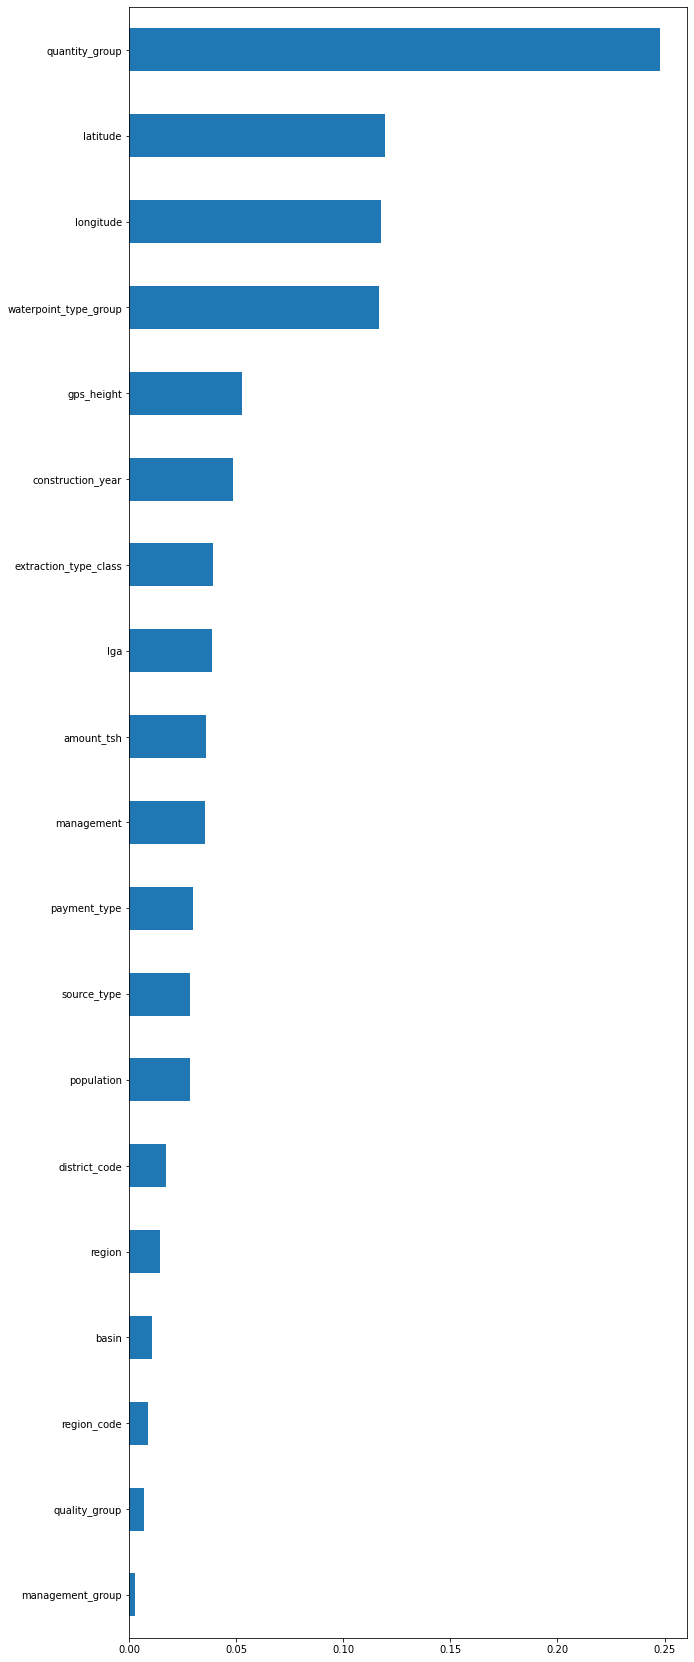

In [20]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
classifier = model.named_steps['decisiontreeclassifier']

print(classifier.get_depth())

columns = X_val.columns
importances = pd.Series(classifier.feature_importances_, columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh()